In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Load the dataset (adjust the file path if necessary)
file_path = (r'C:\Users\disha\Desktop\Cyber\phishingdataset.csv')
df = pd.read_csv(file_path)

# Select only 5000 rows for training and testing
df = df.sample(5000, random_state=42).reset_index(drop=True)

# Display basic info about the dataset
print("Data shape:", df.shape)
print("Columns:", df.columns)


Data shape: (5000, 22)
Columns: Index(['url', 'length_url', 'nb_dots', 'nb_hyphens', 'length_hostname',
       'nb_qm', 'nb_and', 'nb_eq', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'domain_registration_length', 'domain_age',
       'web_traffic', 'dns_record', 'google_index', 'page_rank', 'phish_hints',
       'suspecious_tld', 'login_form', 'external_favicon', 'status'],
      dtype='object')


In [10]:
# Handling missing values (fill with mean for numeric, mode for categorical)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

# Encode categorical columns
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Check the updated data
print(df.head())


    url  length_url  nb_dots  nb_hyphens  length_hostname  nb_qm  nb_and  \
0  4703          35        2           0               11      0       0   
1  1427          22        2           0               15      0       0   
2  4969          43        2           1               15      1       0   
3  1948          26        2           0               18      0       0   
4  1212          62        2           1               13      1       0   

   nb_eq  https_token  ratio_digits_url  ...  domain_age  web_traffic  \
0      0            0          0.000000  ...       11039       178542   
1      0            1          0.000000  ...          -1            0   
2      1            0          0.000000  ...        5636            2   
3      0            1          0.153846  ...        1938      2636665   
4      1            1          0.016129  ...        1853            0   

   dns_record  google_index  page_rank  phish_hints  suspecious_tld  \
0           0             0      

In [22]:
# Define features and target
X = df.drop('login_form', axis=1)  # Adjust the column name as needed
y = df['login_form']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (3500, 21)
Testing set size: (1500, 21)


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9453333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       746
           1       0.94      0.95      0.95       754

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500


Confusion Matrix:
 [[704  42]
 [ 40 714]]


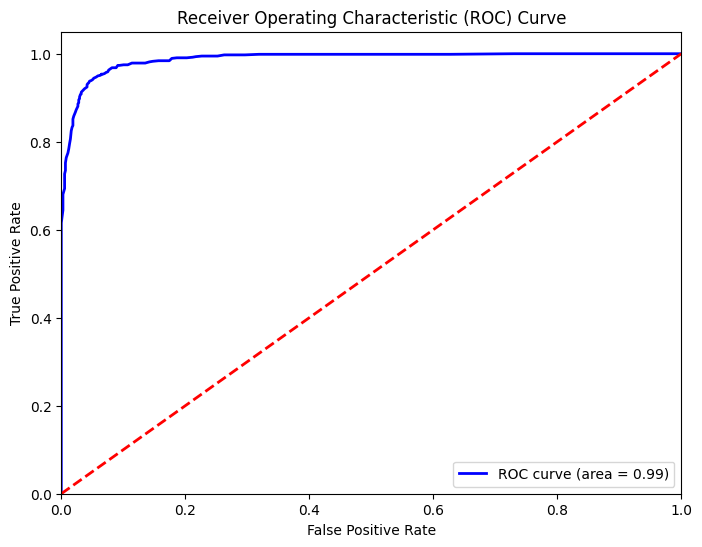

In [13]:
# Plot ROC curve
y_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [15]:
# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print the classification report
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       746
           1       0.94      0.95      0.95       754

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500

Confusion Matrix:
[[704  42]
 [ 40 714]]


In [17]:
import joblib

# Save the trained model
joblib.dump(model, 'phishing_model.pkl')
print("Model saved as 'phishing_model.pkl'")


Model saved as 'phishing_model.pkl'


In [18]:
# app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load the trained model
model = joblib.load('phishing_model.pkl')

# Define feature input function
def extract_input_features():
    length_url = st.number_input('Length of URL', value=50)
    length_hostname = st.number_input('Length of Hostname', value=20)
    nb_dots = st.number_input('Number of Dots', value=2)
    nb_hyphens = st.number_input('Number of Hyphens', value=1)
    nb_at = st.number_input('Number of @ symbols', value=0)
    nb_qm = st.number_input('Number of Question Marks', value=0)
    nb_and = st.number_input('Number of & symbols', value=0)
    nb_eq = st.number_input('Number of Equal signs', value=0)
    nb_underscore = st.number_input('Number of Underscores', value=0)
    nb_percent = st.number_input('Number of Percent symbols', value=0)
    nb_slash = st.number_input('Number of Slashes', value=5)
    nb_colon = st.number_input('Number of Colons', value=1)
    nb_subdomains = st.number_input('Number of Subdomains', value=1)
    prefix_suffix = st.number_input('Prefix Suffix', value=0)
    random_domain = st.number_input('Random Domain', value=0)
    web_traffic = st.number_input('Web Traffic', value=500)
    page_rank = st.number_input('Page Rank', value=1)

    features = np.array([length_url, length_hostname, nb_dots, nb_hyphens, nb_at,
                         nb_qm, nb_and, nb_eq, nb_underscore, nb_percent, nb_slash,
                         nb_colon, nb_subdomains, prefix_suffix, random_domain,
                         web_traffic, page_rank]).reshape(1, -1)
    return features

# Streamlit app UI
st.title('Phishing Website Detection')
st.write('Enter the details of the URL to predict if it is phishing or legitimate.')

input_features = extract_input_features()

if st.button('Predict'):
    prediction = model.predict(input_features)
    result = 'Phishing' if prediction[0] == 1 else 'Legitimate'
    st.write(f'The website is predicted as: **{result}**')


2024-10-24 09:28:25.144 
  command:

    streamlit run C:\Users\disha\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]
